[*********************100%***********************]  1 of 1 completed

                       Portfolio_BuyHold  Portfolio_LongShort  \
Total Return (%)              245.944819            -0.013617   
Annualized Return (%)         249.396770            -0.013726   
Volatility (%)                 48.458209             0.016279   
Sharpe Ratio                    5.105363          -123.700230   
Max Drawdown (%)              -18.293991            -0.030125   

                       Portfolio_DayTrade  Portfolio_LongShort_Filtered  
Total Return (%)                -0.003157                     -0.004794  
Annualized Return (%)           -0.003182                     -0.004832  
Volatility (%)                   0.016299                      0.007272  
Sharpe Ratio                  -122.899102                   -275.706899  
Max Drawdown (%)                -0.020590                     -0.011576  



/var/folders/7t/w_z_kl651qb6nh29r7s4fr2m0000gn/T/ipykernel_91771/3921560786.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data['Date'] = stock_data.index


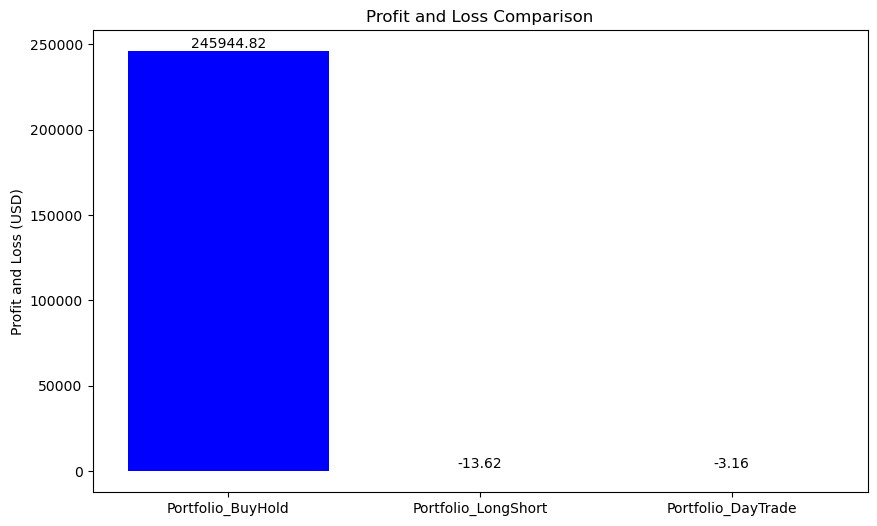

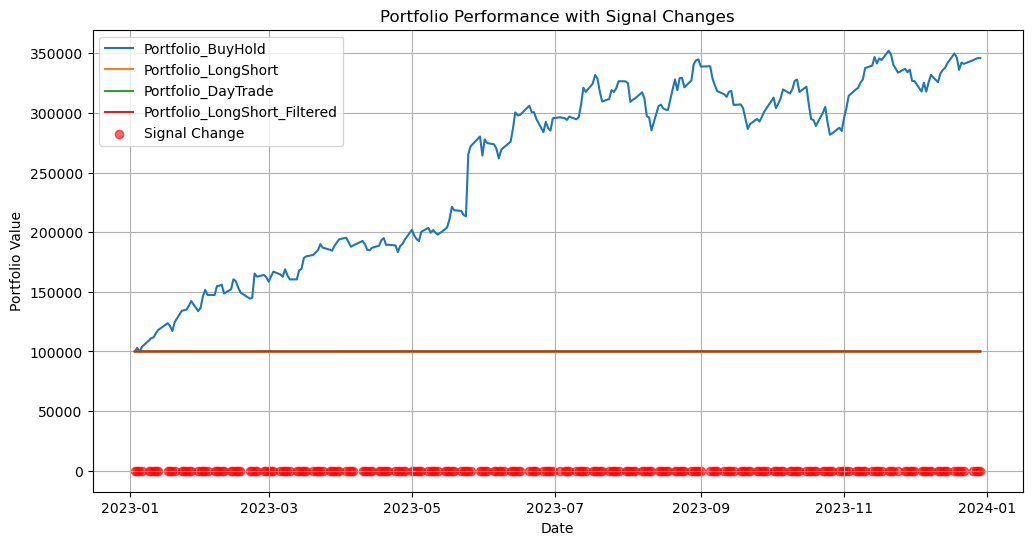

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

# Step 1: Fetch stock price data
start_date = "2023-01-01"
end_date = "2024-01-01"
stock_symbol = "NVDA"  # Replace with your target stock symbol
stock_data = yf.download(stock_symbol, start=start_date, end=end_date)[['Close']]
stock_data['Date'] = stock_data.index
stock_data = stock_data.reset_index(drop=True)

# Simulated predicted returns for demonstration
np.random.seed(42)
predicted_returns = np.random.normal(0, 0.02, len(stock_data))  # Simulated returns

# Step 2: Function to calculate portfolio metrics
def evaluate_strategy(stock_data, strategies):
    metrics = {}
    for strategy in strategies:
        total_return = (stock_data[strategy].iloc[-1] - stock_data[strategy].iloc[0]) / stock_data[strategy].iloc[0] * 100
        annualized_return = ((1 + total_return / 100) ** (1 / (len(stock_data) / 252)) - 1) * 100
        volatility = stock_data[strategy].pct_change().std() * np.sqrt(252) * 100
        max_drawdown = ((stock_data[strategy] / stock_data[strategy].cummax()) - 1).min() * 100
        sharpe_ratio = (annualized_return - 2) / volatility  # Assuming risk-free rate = 2%
        metrics[strategy] = [total_return, annualized_return, volatility, sharpe_ratio, max_drawdown]
    return pd.DataFrame(metrics, index=["Total Return (%)", "Annualized Return (%)", "Volatility (%)", "Sharpe Ratio", "Max Drawdown (%)"])

# Step 3: Define trading rules and portfolios
def trading_rules_optimized(stock_data, predicted_returns, threshold=0.01):
    stock_data['Predicted_Return'] = predicted_returns
    stock_data['Signal_BuyHold'] = 1
    stock_data['Signal_LongShort'] = np.where(stock_data['Predicted_Return'] > threshold, 1, -1)
    stock_data['Signal_DayTrade'] = np.sign(stock_data['Predicted_Return'])

    initial_balance = 100000
    position = initial_balance / stock_data['Close'].iloc[0]

    stock_data['Portfolio_BuyHold'] = position * stock_data['Close']
    stock_data['Portfolio_LongShort'] = (
        initial_balance + 
        (stock_data['Signal_LongShort'].shift(1) * stock_data['Close'].diff()).fillna(0).cumsum()
    )
    stock_data['Portfolio_DayTrade'] = (
        initial_balance +
        (stock_data['Signal_DayTrade'].shift(1) * stock_data['Close'].diff()).fillna(0).cumsum()
    )
    return stock_data

# Step 4: Apply optimized rules and calculate filtered signals
stock_data = trading_rules_optimized(stock_data, predicted_returns, threshold=0.01)

# Filter noise from Long-Short signals
def generate_signals_with_filters(predicted_returns, threshold=0.02):
    signals = pd.Series(0, index=predicted_returns.index)
    signals[predicted_returns > threshold] = 1
    signals[predicted_returns < -threshold] = -1
    return signals

stock_data['Signal_LongShort_Filtered'] = generate_signals_with_filters(stock_data['Predicted_Return'], threshold=0.02)
stock_data['Portfolio_LongShort_Filtered'] = (
    100000 + 
    (stock_data['Signal_LongShort_Filtered'].shift(1) * stock_data['Close'].diff()).fillna(0).cumsum()
)

# Step 5: Evaluate strategies
strategies = ['Portfolio_BuyHold', 'Portfolio_LongShort', 'Portfolio_DayTrade']
performance_metrics = evaluate_strategy(stock_data, strategies + ['Portfolio_LongShort_Filtered'])
print(performance_metrics)

# Step 6: Visualize P&L comparison
def plot_pnl_comparison(stock_data, strategies):
    pnl_data = [stock_data[strategy].iloc[-1] - stock_data[strategy].iloc[0] for strategy in strategies]
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.bar(strategies, pnl_data, color=['blue', 'green', 'orange', 'red'])
    ax.set_title("Profit and Loss Comparison")
    ax.set_ylabel("Profit and Loss (USD)")
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:.2f}', ha='center', va='bottom', fontsize=10)
    plt.show()

plot_pnl_comparison(stock_data, strategies)

# Step 7: Visualize portfolio performance
plt.figure(figsize=(12, 6))
for strategy in strategies + ['Portfolio_LongShort_Filtered']:
    plt.plot(stock_data['Date'], stock_data[strategy], label=strategy)
plt.scatter(stock_data['Date'], stock_data['Signal_LongShort_Filtered'], color='red', label='Signal Change', alpha=0.6)
plt.title('Portfolio Performance with Signal Changes')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.grid(True)
plt.show()